In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
PI = np.pi

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def generate_linearly_separable_data(N=100):
    theta = np.linspace(0, 2*PI, N)
    a = 0.4
    b = 0.4
    r1 = np.random.rand(N)*0.2
    x1 = a + r1*np.cos(theta) + (np.random.rand(N)-0.5)/50
    y1 = b + r1*np.sin(theta) + (np.random.rand(N)-0.5)/50
    c = 0.7
    d = 0.7
    r2 = np.random.rand(N)*0.2
    x2 = c + r2*np.cos(theta) + (np.random.rand(N)-0.5)/50
    y2 = d + r2*np.sin(theta) + (np.random.rand(N)-0.5)/50
    return x1, y1, x2, y2

def generate_moon_data(N=100):
    x1 = np.linspace(PI/4, 3*PI/4, N) + (np.random.rand(N)-0.5)/100
    x2 = np.linspace(5*PI/4, 7*PI/4, N) + (np.random.rand(N)-0.5)/100
    y1 = np.sin(x1) - 0.23 + (np.random.rand(N)-0.5)/4
    y2 = np.sin(x2) + 1.2 + (np.random.rand(N)-0.5)/4
    x1 = x1/PI
    x2 = (x2-PI+PI/4)/PI
    return x1-0.1, y1, x2-0.1, y2

def generate_Saturn_data(N=100):
    theta = np.linspace(0, 2*PI, N) + PI*(np.random.rand(N))/100
    a = 0.5
    b = 0.5
    r1 = 0.4 + 2*(np.random.rand(N)-0.5)/10
    x1 = a + r1*np.cos(theta) + (np.random.rand(N)-0.5)/50
    y1 = b + r1*np.sin(theta) + (np.random.rand(N)-0.5)/50
    r2 = 0.2*np.random.rand(N)
    x2 = a + r2*np.cos(theta) + (np.random.rand(N)-0.5)/50
    y2 = b + r2*np.sin(theta) + (np.random.rand(N)-0.5)/50
    return x1, y1, x2, y2


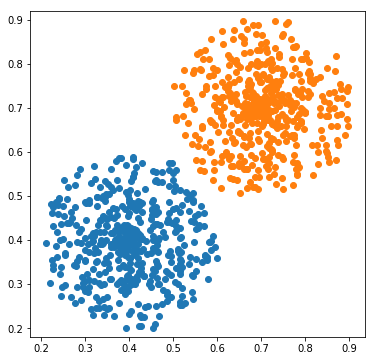

In [3]:
x1, y1, x2, y2 = generate_linearly_separable_data(500)
plt.figure(figsize=(6,6))
plt.axis('equal')
plt.scatter(x1, y1)
plt.scatter(x2, y2)

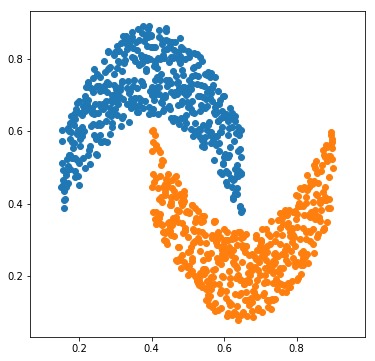

In [4]:
x1, y1, x2, y2 = generate_moon_data(N=500)
plt.figure(figsize=(6,6))
plt.axis('equal')
plt.scatter(x1, y1)
plt.scatter(x2, y2)

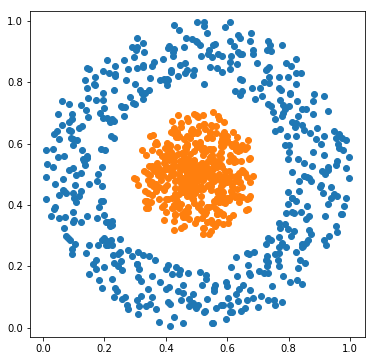

In [5]:
x1, y1, x2, y2 = generate_Saturn_data(500)
plt.figure(figsize=(6,6))
plt.axis('equal')
plt.scatter(x1, y1)
plt.scatter(x2, y2)

In [20]:
def gen_data(data_type='linear', N=100, hold=1.0, out=1.0):
    n = int(2*N)
    if 'linear' == data_type:
        x1, y1, x2, y2 = generate_linearly_separable_data(N)
    elif 'moon' == data_type:
        x1, y1, x2, y2 = generate_moon_data(N)
    elif 'saturn' == data_type:
        x1, y1, x2, y2 = generate_Saturn_data(N)
    else:
        raise ValueError('data type must be one of linear, moon, or saturn.')
    hold_ = int(hold/(hold+out)*N)
    indcies = np.random.permutation(N)

    x_train = np.zeros((2*hold_, 2))
    y_train = np.zeros((2*hold_, 2))
    x_train[0:hold_,0] = x1[indcies[0:hold_]]
    x_train[0:hold_,1] = y1[indcies[0:hold_]]
    y_train[0:hold_,0] = 1.0
    x_train[hold_:, 0] = x2[indcies[0:hold_]]
    x_train[hold_:, 1] = y2[indcies[0:hold_]]
    y_train[hold_:, 1] = 1.0

    x_test = np.zeros((2*(N-hold_), 2))
    y_test = np.zeros((2*(N-hold_), 2))
    x_test[0:(N-hold_), 0] = x1[indcies[hold_:,]]
    x_test[0:(N-hold_), 1] = y1[indcies[hold_:,]]
    y_test[0:(N-hold_), 0] = 1.0
    x_test[N-hold_:, 0] = x2[indcies[hold_:,]]
    x_test[N-hold_:, 1] = y2[indcies[hold_:,]]
    y_test[N-hold_:, 1] = 1.0

    return {'train_set':(x_train, y_train), 'test_set':(x_test, y_test)}

In [7]:
data_linear = gen_data(data_type='linear', N=1000, hold=1.0, out=1.0)
learning_rate = 0.001
batch_size = 100
epochs = 8000

tf.reset_default_graph()
x = tf.placeholder(dtype=tf.float32, shape=(None, 2), name='samples')
y = tf.placeholder(dtype=tf.float32, shape=(None, 2), name='labels')

W = tf.Variable(tf.zeros(shape=(2,2)), name='weight')
b = tf.Variable(tf.zeros(shape=(2)), name='bias')

pred = tf.nn.softmax(tf.matmul(x, W) + b, name='pred')
# for train
cost = tf.reduce_mean(tf.square(y-pred))
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train = optimizer.minimize(cost)
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accurary = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
init_op = tf.global_variables_initializer()

saver = tf.train.Saver()
with tf.Session() as sess:
    tf.summary.scalar('cost', cost)
    tf.summary.histogram('weight', W)
    tf.summary.scalar('accurary', accurary)
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter('./log/linear_model/train', sess.graph)
    test_writer = tf.summary.FileWriter('./log/linear_model/test', sess.graph)
    sess.run(init_op)
    x_train, y_train = data_linear['train_set']
    x_test, y_test = data_linear['test_set']
    num_samples = len(x_train)
    for epoch in range(epochs):
        steps = int(num_samples / batch_size)
        indices = np.random.permutation(num_samples)
        x_train_ = x_train[indices]
        y_train_ = y_train[indices]
        for step in range(steps):
            start = step*batch_size
            end = start + batch_size
            x_ = x_train_[start:end,:]
            y_ = y_train_[start:end,:]
            summary, _, c = sess.run([merged, train, cost], feed_dict={x:x_, y:y_})
            train_writer.add_summary(summary)
        if epoch%100 == 99:
            summary, acc = sess.run([merged, accurary], feed_dict={x:x_test, y:y_test})
            test_writer.add_summary(summary, epoch)
            print("Epoch:{:5d}, Accurary:{:.2f}".format(epoch, acc))
    print('W:', W.eval())
    print('b:', b.eval())
    train_writer.close()
    test_writer.close()
    print("Training Finished!")
    save_path = saver.save(sess, './log/linear_model/linear_model.ckpt')
    print('model saved in path: ', save_path)

Epoch:   99, Accurary:0.50
Epoch:  199, Accurary:0.50
Epoch:  299, Accurary:0.50
Epoch:  399, Accurary:0.50
Epoch:  499, Accurary:0.50
Epoch:  599, Accurary:0.52
Epoch:  699, Accurary:0.55
Epoch:  799, Accurary:0.59
Epoch:  899, Accurary:0.62
Epoch:  999, Accurary:0.68
Epoch: 1099, Accurary:0.72
Epoch: 1199, Accurary:0.78
Epoch: 1299, Accurary:0.82
Epoch: 1399, Accurary:0.85
Epoch: 1499, Accurary:0.88
Epoch: 1599, Accurary:0.88
Epoch: 1699, Accurary:0.91
Epoch: 1799, Accurary:0.92
Epoch: 1899, Accurary:0.93
Epoch: 1999, Accurary:0.93
Epoch: 2099, Accurary:0.94
Epoch: 2199, Accurary:0.94
Epoch: 2299, Accurary:0.94
Epoch: 2399, Accurary:0.95
Epoch: 2499, Accurary:0.96
Epoch: 2599, Accurary:0.96
Epoch: 2699, Accurary:0.96
Epoch: 2799, Accurary:0.97
Epoch: 2899, Accurary:0.97
Epoch: 2999, Accurary:0.97
Epoch: 3099, Accurary:0.97
Epoch: 3199, Accurary:0.97
Epoch: 3299, Accurary:0.97
Epoch: 3399, Accurary:0.98
Epoch: 3499, Accurary:0.98
Epoch: 3599, Accurary:0.99
Epoch: 3699, Accurary:0.99
E

INFO:tensorflow:Restoring parameters from ./log/linear_model/linear_model.ckpt


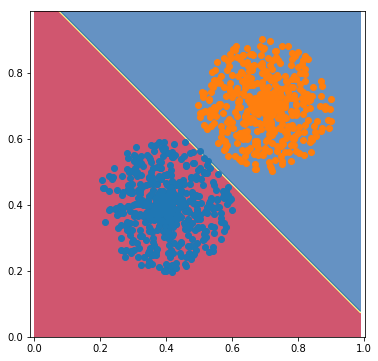

In [8]:
xmin, xmax = 0.0, 1.0
ymin, ymax = 0.0, 1.0
delta = 0.01
xx, yy = np.meshgrid(np.arange(xmin, xmax, delta), np.arange(ymin, ymax, delta))
x = np.c_[xx.ravel(), yy.ravel()]
saver1 = tf.train.import_meta_graph('./log/linear_model/linear_model.ckpt.meta')
with tf.Session() as sess:
    saver1.restore(sess, './log/linear_model/linear_model.ckpt')
    samples = sess.graph.get_tensor_by_name('samples:0')
    pred = sess.graph.get_tensor_by_name('pred:0')
    predictions = sess.run(pred, feed_dict={samples:x})
    z = np.argmax(predictions, axis=1)
    z = z.reshape(xx.shape)
    plt.figure(figsize=(6,6))
    plt.contourf(xx, yy, z, cmap=plt.cm.Spectral, alpha=0.8)
    x_test, y_test = data_linear['test_set']
    p1_x = x_test[y_test[:,0]==1,0]
    p1_y = x_test[y_test[:,0]==1,1]
    plt.scatter(p1_x, p1_y)
    p2_x = x_test[y_test[:,1]==1,0]
    p2_y = x_test[y_test[:,1]==1,1]
    plt.scatter(p2_x, p2_y)
    plt.axis('equal')

In [17]:
data_moon = gen_data(data_type='moon', N=1000, hold=1.0, out=1.0)
learning_rate = 0.01
batch_size = 100
epochs = 3000

tf.reset_default_graph()

x = tf.placeholder(dtype=tf.float32, shape=(None, 2), name='samples')
y = tf.placeholder(dtype=tf.float32, shape=(None, 2), name='labels')

W1 = tf.Variable(tf.random_normal(shape=(2,32), mean=0.0, stddev=1), name='weight1')
b1 = tf.Variable(tf.zeros(shape=[32]), name='bias1')
W2 = tf.Variable(tf.random_normal(shape=(32,8)), name='weight2')
b2 = tf.Variable(tf.zeros(shape=[8]), name='bias2')
W3 = tf.Variable(tf.random_normal(shape=(8,2)), name='weight3')
b3 = tf.Variable(tf.zeros(shape=[2]), name='bias3')
z = tf.matmul(x, W1) + b1
# layer1 = tf.nn.relu(z, name='layer1')
layer1 = tf.tanh(z, name='layer1')
# layer1 = tf.sigmoid(z, name='layer1')
z = tf.matmul(layer1, W2) + b2
layer2 = tf.tanh(z, name='layer2')
out = tf.matmul(layer2, W3) + b3
pred = tf.nn.softmax(out, name='pred')
# for train
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=out))
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train = optimizer.minimize(cost)
# for test
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accurary = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
# initialization op
init_op = tf.global_variables_initializer()
x_train, y_train = data_moon['train_set']
x_test, y_test = data_moon['test_set']
# model saver
saver = tf.train.Saver()
with tf.Session() as sess:
    tf.summary.scalar('cost', cost)
    tf.summary.histogram('weight', W1)
    tf.summary.histogram('weight', W2)
    tf.summary.scalar('accurary', accurary)
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter('./log/moon_model/train', sess.graph)
    test_writer = tf.summary.FileWriter('./log/moon_model/test', sess.graph)
    sess.run(init_op)
    num_samples = len(x_train)
    for epoch in range(epochs):
        steps = int(num_samples / batch_size)
        indices = np.random.permutation(num_samples)
        x_train_ = x_train[indices]
        y_train_ = y_train[indices]
        for step in range(steps):
            start = step*batch_size
            end = start + batch_size
            x_ = x_train_[start:end,:]
            y_ = y_train_[start:end,:]
            summary, _, c = sess.run([merged, train, cost], feed_dict={x:x_, y:y_})
            train_writer.add_summary(summary)
        if epoch%100 == 99:
            summary, acc = sess.run([merged, accurary], feed_dict={x:x_test, y:y_test})
            test_writer.add_summary(summary, epoch)
            print("Epoch:{:5d}, Accurary:{:.2f}".format(epoch, acc))
    print('W1:', W1.eval())
    print('b1:', b1.eval())
    print('W2:', W2.eval())
    print('b2:', b2.eval())
    train_writer.close()
    test_writer.close()
    print("Training Finished!")
    save_path = saver.save(sess, './log/moon_model/moon_model.ckpt')
    print('model saved in path: ', save_path)

Epoch:   99, Accurary:0.95
Epoch:  199, Accurary:0.96
Epoch:  299, Accurary:0.96
Epoch:  399, Accurary:0.96
Epoch:  499, Accurary:0.96
Epoch:  599, Accurary:0.96
Epoch:  699, Accurary:0.96
Epoch:  799, Accurary:0.97
Epoch:  899, Accurary:0.97
Epoch:  999, Accurary:0.97
Epoch: 1099, Accurary:0.97
Epoch: 1199, Accurary:0.98
Epoch: 1299, Accurary:0.98
Epoch: 1399, Accurary:0.98
Epoch: 1499, Accurary:0.99
Epoch: 1599, Accurary:0.99
Epoch: 1699, Accurary:0.99
Epoch: 1799, Accurary:0.99
Epoch: 1899, Accurary:1.00
Epoch: 1999, Accurary:1.00
Epoch: 2099, Accurary:1.00
Epoch: 2199, Accurary:1.00
Epoch: 2299, Accurary:1.00
Epoch: 2399, Accurary:1.00
Epoch: 2499, Accurary:1.00
Epoch: 2599, Accurary:1.00
Epoch: 2699, Accurary:1.00
Epoch: 2799, Accurary:1.00
Epoch: 2899, Accurary:1.00
Epoch: 2999, Accurary:1.00
W1: [[ 0.5335421   0.3921538   1.1846604   0.11977174 -0.34904215  0.2587205
  -2.1298683   0.13150938  0.6897056  -0.40765655  1.8100176   0.5066141
  -0.343038    3.3587387  -0.9172882   0

INFO:tensorflow:Restoring parameters from ./log/moon_model/moon_model.ckpt


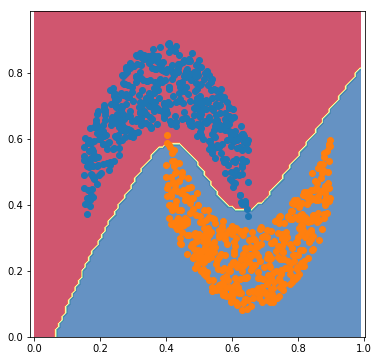

In [18]:
xmin, xmax = 0.0, 1.0
ymin, ymax = 0.0, 1.0
delta = 0.01
xx, yy = np.meshgrid(np.arange(xmin, xmax, delta), np.arange(ymin, ymax, delta))
x = np.c_[xx.ravel(), yy.ravel()]
tf.reset_default_graph()
saver1 = tf.train.import_meta_graph('./log/moon_model/moon_model.ckpt.meta')
with tf.Session() as sess:
    saver1.restore(sess, './log/moon_model/moon_model.ckpt')
    samples = sess.graph.get_tensor_by_name('samples:0')
    pred = sess.graph.get_tensor_by_name('pred:0')
    predictions = sess.run(pred, feed_dict={samples:x})
    z = np.argmax(predictions, axis=1)
    z = z.reshape(xx.shape)
    plt.figure(figsize=(6, 6))
    plt.contourf(xx, yy, z, cmap=plt.cm.Spectral, alpha=0.8)
    x_test, y_test = data_moon['test_set']
    p1_x = x_test[y_test[:,0]==1,0]
    p1_y = x_test[y_test[:,0]==1,1]
    plt.scatter(p1_x, p1_y)
    p2_x = x_test[y_test[:,1]==1,0]
    p2_y = x_test[y_test[:,1]==1,1]
    plt.scatter(p2_x, p2_y)
    plt.axis('equal')

In [25]:
data_saturn = gen_data(data_type='saturn', N=1000, hold=1.0, out=1.0)
learning_rate = 0.01
batch_size = 100
epochs = 1000

tf.reset_default_graph()

x = tf.placeholder(dtype=tf.float32, shape=(None, 2), name='samples')
y = tf.placeholder(dtype=tf.float32, shape=(None, 2), name='labels')

W1 = tf.Variable(tf.random_normal(shape=(2,3), mean=0.0, stddev=1), name='weight1')
b1 = tf.Variable(tf.zeros(shape=(3)), name='bias1')
W2 = tf.Variable(tf.random_normal(shape=(3,6)), name='weight2')
b2 = tf.Variable(tf.zeros(shape=(6)), name='bias2')
W3 = tf.Variable(tf.random_normal(shape=(6,9)), name='weight3')
b3 = tf.Variable(tf.zeros(shape=(9)), name='bias3')
W4 = tf.Variable(tf.random_normal(shape=(9,2)), name='weight4')
b4 = tf.Variable(tf.zeros(shape=(2)), name='bias4')
z = tf.matmul(x, W1) + b1
# layer1 = tf.nn.relu(z, name='layer1')
# layer1 = tf.tanh(z, name='layer1')
layer1 = tf.tanh(z, name='layer1')
z = tf.matmul(layer1, W2) + b2
layer2 = tf.tanh(z, name='layer2')
z = tf.matmul(layer2, W3) + b3
layer3 = tf.tanh(z, name='layer3')
out = tf.matmul(layer3, W4) + b4
pred = tf.nn.softmax(out, name='pred')
# for train
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=out))
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train = optimizer.minimize(cost)
# for test
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accurary = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
# initialization op
init_op = tf.global_variables_initializer()
x_train, y_train = data_saturn['train_set']
x_test, y_test = data_saturn['test_set']
# model saver
saver = tf.train.Saver()
with tf.Session() as sess:
    tf.summary.scalar('cost', cost)
    tf.summary.histogram('weight1', W1)
    tf.summary.histogram('weight2', W2)
    tf.summary.histogram('weight3', W3)
    tf.summary.histogram('weight4', W4)
    tf.summary.scalar('accurary', accurary)
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter('./log/saturn_model/train', sess.graph)
    test_writer = tf.summary.FileWriter('./log/saturn_model/test', sess.graph)
    sess.run(init_op)
    num_samples = len(x_train)
    for epoch in range(epochs):
        steps = int(num_samples / batch_size)
        indices = np.random.permutation(num_samples)
        x_train_ = x_train[indices]
        y_train_ = y_train[indices]
        for step in range(steps):
            start = step*batch_size
            end = start + batch_size
            x_ = x_train_[start:end,:]
            y_ = y_train_[start:end,:]
            summary, _, c = sess.run([merged, train, cost], feed_dict={x:x_, y:y_})
            train_writer.add_summary(summary)
        if epoch%10 == 9:
            summary, acc = sess.run([merged, accurary], feed_dict={x:x_test, y:y_test})
            test_writer.add_summary(summary, epoch)
            print("Epoch:{:5d}, Accurary:{:.2f}".format(epoch, acc))
    print('W1:', W1.eval())
    print('b1:', b1.eval())
    print('W2:', W2.eval())
    print('b2:', b2.eval())
    train_writer.close()
    test_writer.close()
    print("Training Finished!")
    save_path = saver.save(sess, './log/saturn_model/saturn_model.ckpt')
    print('model saved in path: ', save_path)

Epoch:    9, Accurary:0.65
Epoch:   19, Accurary:0.65
Epoch:   29, Accurary:0.75
Epoch:   39, Accurary:0.83
Epoch:   49, Accurary:0.83
Epoch:   59, Accurary:0.81
Epoch:   69, Accurary:0.84
Epoch:   79, Accurary:0.83
Epoch:   89, Accurary:0.81
Epoch:   99, Accurary:0.81
Epoch:  109, Accurary:0.84
Epoch:  119, Accurary:0.82
Epoch:  129, Accurary:0.81
Epoch:  139, Accurary:0.79
Epoch:  149, Accurary:0.81
Epoch:  159, Accurary:0.81
Epoch:  169, Accurary:0.81
Epoch:  179, Accurary:0.84
Epoch:  189, Accurary:0.81
Epoch:  199, Accurary:0.82
Epoch:  209, Accurary:0.82
Epoch:  219, Accurary:0.80
Epoch:  229, Accurary:0.81
Epoch:  239, Accurary:0.81
Epoch:  249, Accurary:0.80
Epoch:  259, Accurary:0.81
Epoch:  269, Accurary:0.81
Epoch:  279, Accurary:0.81
Epoch:  289, Accurary:0.82
Epoch:  299, Accurary:0.81
Epoch:  309, Accurary:0.81
Epoch:  319, Accurary:0.82
Epoch:  329, Accurary:0.81
Epoch:  339, Accurary:0.83
Epoch:  349, Accurary:0.81
Epoch:  359, Accurary:0.82
Epoch:  369, Accurary:0.82
E

INFO:tensorflow:Restoring parameters from ./log/saturn_model/saturn_model.ckpt


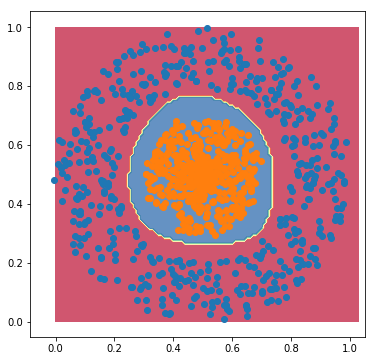

In [26]:
xmin, xmax = 0.0, 1.04
ymin, ymax = 0.0, 1.01
delta = 0.01
xx, yy = np.meshgrid(np.arange(xmin, xmax, delta), np.arange(ymin, ymax, delta))
x = np.c_[xx.ravel(), yy.ravel()]
tf.reset_default_graph()
saver1 = tf.train.import_meta_graph('./log/saturn_model/saturn_model.ckpt.meta')
with tf.Session() as sess:
    saver1.restore(sess, './log/saturn_model/saturn_model.ckpt')
    samples = sess.graph.get_tensor_by_name('samples:0')
    pred = sess.graph.get_tensor_by_name('pred:0')
    predictions = sess.run(pred, feed_dict={samples:x})
    z = np.argmax(predictions, axis=1)
    z = z.reshape(xx.shape)
    plt.figure(figsize=(6,6))
    plt.contourf(xx, yy, z, cmap=plt.cm.Spectral, alpha=0.8)
    x_test, y_test = data_saturn['test_set']
    p1_x = x_test[y_test[:,0]==1,0]
    p1_y = x_test[y_test[:,0]==1,1]
    plt.scatter(p1_x, p1_y)
    p2_x = x_test[y_test[:,1]==1,0]
    p2_y = x_test[y_test[:,1]==1,1]
    plt.scatter(p2_x, p2_y)
    plt.axis('equal')